# Guided Project - Predicting Car Prices

In [1]:
import pandas as pd

In [75]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

data = pd.read_csv('imports-85.data',names=cols)

In [76]:
data.head(3)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500


In [77]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

numeric_cars = data[continuous_values_cols]

numeric_cars.head(3)

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500


## Data Cleaning

In [78]:
import numpy as np

numeric_cars = numeric_cars.replace('?', np.nan)


In [79]:
numeric_cars = numeric_cars.astype('float')


In [80]:
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [81]:
numeric_cars = numeric_cars.dropna(subset=['price'])

In [82]:
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

In [83]:
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

## Re-scaling

In [84]:
price_col = numeric_cars['price']

etendue = numeric_cars.max() - numeric_cars.min()
numeric_cars = (numeric_cars-numeric_cars.min()) / etendue

numeric_cars['price'] = price_col

In [85]:
numeric_cars.head(3)

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.664286,0.290476,0.125,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.664286,0.290476,0.125,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.100000,0.666667,0.125,0.495327,0.346939,0.166667,0.263158,16500.0


## Univariate Model

In [86]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(features,target,dataframe):
    number_test = int(dataframe.shape[0]*0.75)
    train = dataframe.iloc[:number_test,:]
    test = dataframe.iloc[number_test:,:]
    
    knn = KNeighborsRegressor()
    knn.fit(train[features],train[target])
    predictions = knn.predict(test[features])
    
    mse = mean_squared_error(predictions,test[target])
    
    return mse**(1/2)

rmses = dict()

for col in numeric_cars.columns:
    if col != 'price':
        rmses[col]=knn_train_test([col],'price',numeric_cars)
    
best_col = min(rmses.keys(),key=(lambda x:rmses[x]))

print('Meilleure colonne : {} avec rmse de {}'.format(best_col,rmses[best_col]))

    

Meilleure colonne : curb-weight avec rmse de 2467.1015390375746


In [87]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

def knn_train_test(features,target,dataframe,k_value):
    kf = KFold(n_splits=k_value,
           shuffle=True,
           random_state=1)

    mses = cross_val_score(KNeighborsRegressor(),
                       dataframe[features],
                       dataframe[target],
                       scoring="neg_mean_squared_error",
                       cv=kf)
 
    return np.mean(np.sqrt(np.absolute(mses)))

print(knn_train_test(['curb-weight'],'price',numeric_cars,5))

4310.7102771908085


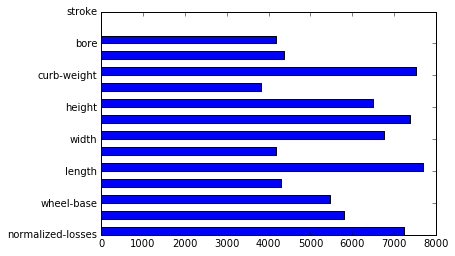

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline

labels=list()
rmse=list()

for col in numeric_cars.columns:
    if col != 'price':
        values=list()
        for k in [2, 3, 5, 7, 9]: 
            values.append(knn_train_test([col],
                          'price',
                          numeric_cars,
                          k))
            
        labels.append(col)
        rmse.append(np.mean(values))
            
fig,ax = plt.subplots()

ax.set_yticklabels(labels,rotation=0)

ax.barh(range(len(labels)),rmse,0.5)

plt.show()


## Multivariate

In [106]:
results = pd.Series(rmse,index=labels)
results = results.sort_values()

In [107]:
results

horsepower           3811.069459
curb-weight          4165.458665
highway-mpg          4180.377564
width                4291.062536
city-mpg             4368.253554
length               5471.853637
wheel-base           5800.505276
compression-rate     6502.499841
bore                 6766.974351
normalized-losses    7230.566021
stroke               7383.742797
peak-rpm             7520.803829
height               7685.384005
dtype: float64

In [113]:
default_k_value = 10
rmses = list()

for num_features in range(1,6):
    rmses.append(knn_train_test(results.index.tolist()[:num_features],
                                'price',
                                numeric_cars,
                                default_k_value))
                                
print(rmses)


[3801.8498705875236, 2841.084708997133, 2938.3705169184386, 2848.278751201201, 3010.8388377674673]


In [114]:
results.index.tolist()[:3]

['horsepower', 'curb-weight', 'highway-mpg']

## Optimizing the k neighbors value

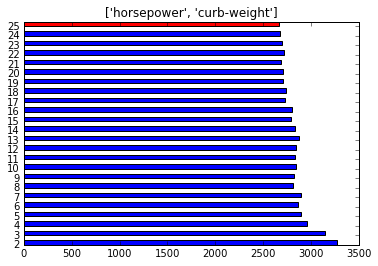

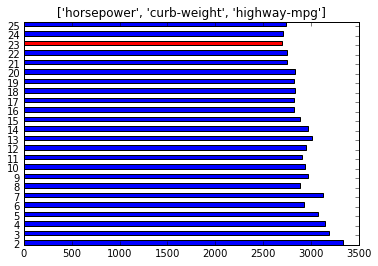

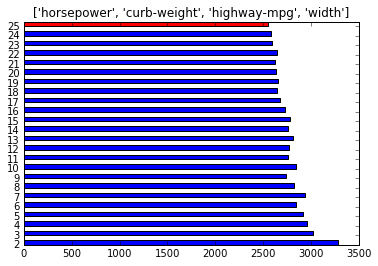

In [130]:
%matplotlib inline

def colors(array):
    array_color=list()
    ind = array.index(min(array))
    for value in array:
        array_color.append('blue')
    array_color[ind]='red'
    return array_color

for num in range(2,5):
    k_rmse=list()
    title = str(results.index.tolist()[:num])
    for k_value in range(2,26):
        k_rmse.append(knn_train_test(results.index.tolist()[:num],
                                'price',
                                numeric_cars,
                                k_value))

    fig,ax = plt.subplots()
    
    ax.set_yticklabels(range(2,26),rotation=0)
    ax.set_yticks(range(2,26))
    ax.barh(range(2,26),k_rmse,0.5,color=colors(k_rmse))
    plt.title(title)
    plt.show()
    

In [117]:
str(results.index.tolist()[:3])

"['horsepower', 'curb-weight', 'highway-mpg']"

In [126]:
li=[1,2,4,5,8,0,9]

def colors(array):
    array_color=list()
    ind = array.index(min(array))
    for value in array:
        array_color.append('blue')
    array_color[ind]='red'
    return array_color

colors(li)

['blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue']